# Multi‑Armed Bandits: Explore‑then‑Commit (ETC) and UCB Algorithms

In this notebook, we analyze a two‑armed Bernoulli bandit where the arms have the following true means:

$$\mu_1 = 0.5, \quad \mu_2 = 0.5 + \Delta,$$

with \(\Delta < 0.5\) and a time horizon of \(T = 10000\). We implement and compare the following methods:

1. **ETC Algorithm:**  
   This approach first explores each arm for \(m\) rounds (using $m = T^{2/3}(\log T)^{1/3}$ in our initial experiment) and then commits to the arm with the higher estimated mean. The sample regret is calculated as

   $$ R = \mu_2 \cdot T - \sum_{t=1}^T \mu(a_t), $$

   where \(a_t\) denotes the arm played at time \(t\).

2. **UCB Algorithm:**  
   We also implement the classic Upper Confidence Bound algorithm, a standard technique for multi‑armed bandit problems.

3. **ETC with Known \(\Delta\):**  
   When the gap \(\Delta\) is known, we set

   $$ m = \left\lceil \frac{2}{\Delta^2}\ln(2T) \right\rceil, $$

   ensuring that the estimation error remains below $\Delta/2\$ with high probability.

For each setting, we perform 500 Monte Carlo simulations and plot the estimated regret as a function of $\Delta\$ to compare the performance of the ETC and UCB algorithms.


In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Global time horizon
T = 10000

# Define the true means for the two arms (for a given Delta, mu1 = 0.5, mu2 = 0.5 + Delta)
def true_means(delta):
    return 0.5, 0.5 + delta

## Part 1: ETC Algorithm with \(\Delta = \frac{1}{4}\) and \(m = T^{2/3}(\log T)^{1/3}\)

In the Explore‑then‑Commit (ETC) strategy, we begin by exploring each arm for \(m\) rounds. For this experiment, we choose

$$
m = T^{2/3}(\log T)^{1/3}.
$$

Once the exploration phase, which spans \(2m\) rounds in total, is complete, we select the arm with the higher estimated mean and commit to it for the remaining \(T - 2m\) rounds. The sample regret is defined as

$$
R = \mu_2 \cdot T - \Bigl[ m\mu_1 + m\mu_2 + (T-2m)\mu(\text{committed arm}) \Bigr].
$$

Given that $\mu_1 = 0.5$ and $\mu_2 = 0.5 + \Delta$, if the algorithm commits to the optimal arm (arm 2), the regret becomes

$$
R = m\Delta,
$$

whereas if it commits to the suboptimal arm (arm 1), the regret is

$$
R = (T - m)\Delta.
$$


In [8]:
def run_etc(T, m, delta):
    """
    Execute a single simulation of the ETC algorithm for a two-armed bandit,
    where the true means are given by mu1 = 0.5 and mu2 = 0.5 + delta.

    The algorithm operates in two phases:
      1. Exploration: Each arm is pulled for m rounds.
      2. Commitment: The arm with the higher empirical mean is chosen
         for the remaining T - 2*m rounds.

    The regret is calculated using the true means.
    """
    # Retrieve the true means for the arms.
    mu1, mu2 = true_means(delta)

    # Exploration phase: Pull each arm m times.
    # We simulate Bernoulli outcomes; for regret, we use the true values.
    samples_arm1 = np.random.binomial(1, mu1, m)
    samples_arm2 = np.random.binomial(1, mu2, m)

    # Compute the empirical means from the exploration samples.
    est_mean1 = np.mean(samples_arm1)
    est_mean2 = np.mean(samples_arm2)

    # Commitment: Choose the arm with the higher empirical mean.
    # In case of a tie, we favor arm 2.
    if est_mean2 >= est_mean1:
        chosen_arm = 2
    else:
        chosen_arm = 1

    # Regret incurred during the exploration phase:
    # Since arm1 is suboptimal, playing it m times yields a regret of m * delta.
    regret_exploration = m * delta

    # Regret during the commitment phase:
    # If the optimal arm (arm 2) is chosen, there is no regret.
    # Otherwise, playing the suboptimal arm for (T - 2*m) rounds results in a regret of (T - 2*m) * delta.
    if chosen_arm == 2:
        regret_commit = 0
    else:
        regret_commit = (T - 2 * m) * delta

    total_regret = regret_exploration + regret_commit
    return total_regret

# Set Delta = 1/4 and determine m using: m = T^(2/3) * (log T)^(1/3)
delta_fixed = 0.25
m_fixed = int(T**(2/3) * (np.log(T))**(1/3))
print('Using m =', m_fixed, 'for T =', T, 'and delta =', delta_fixed)

# Run 500 simulations of the ETC algorithm and compute the average regret.
num_runs = 500
regrets_etc = [run_etc(T, m_fixed, delta_fixed) for _ in range(num_runs)]
avg_regret_etc = np.mean(regrets_etc)
print('ETC average regret for delta = 0.25:', avg_regret_etc)


Using m = 972 for T = 10000 and delta = 0.25
ETC average regret for delta = 0.25: 243.0


## Part 2: ETC for Various Values of \(\Delta\)

We now repeat the ETC experiment (with the same exploration length
 $m = T^{2/3}(\log T)^{1/3}$) for various values of $\Delta \in \{0.05, 0.1, 0.2, 0.3, 0.4, 0.45\}$.

For each $\Delta$ we run 500 simulations and plot the estimated average regret as a function of $\Delta$.

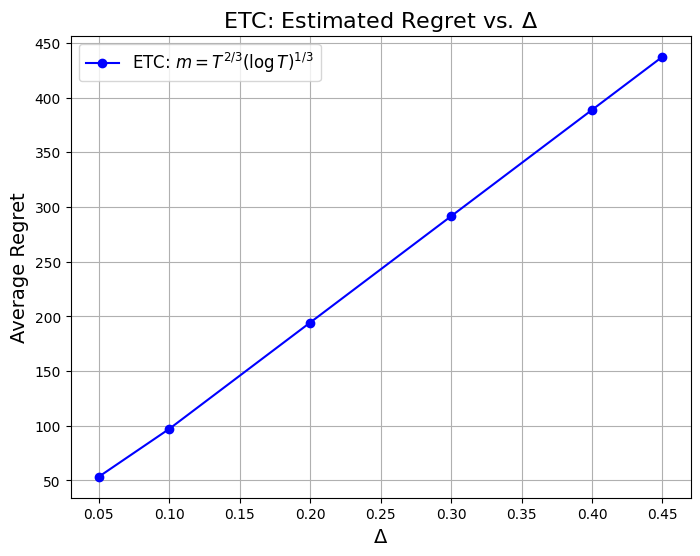

In [9]:
# Define a list of delta values to evaluate.
deltas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.45]
avg_regrets_etc = []

# For each delta value, run the ETC algorithm and record the average regret.
for d in deltas:
    # Here, we use the same exploration budget (m_fixed) for every delta.
    regrets = [run_etc(T, m_fixed, d) for _ in range(num_runs)]
    avg_regrets_etc.append(np.mean(regrets))

# Plot the average regret as a function of delta.
plt.figure(figsize=(8, 6))
plt.plot(deltas, avg_regrets_etc, 'bo-', label=r'ETC: $m=T^{2/3}(\log T)^{1/3}$')
plt.xlabel(r'$\Delta$', fontsize=14)
plt.ylabel('Average Regret', fontsize=14)
plt.title('ETC: Estimated Regret vs. $\Delta$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Part 3: UCB Algorithm and Comparison with ETC

We now implement the UCB algorithm. Initially, each arm is played once, and for every round \(t\) from 3 to \(T\), we choose the arm that maximizes the index:

$$
\text{UCB}_i = \hat{\mu}_i + \sqrt{\frac{2\ln t}{n_i}},
$$

where $\hat{\mu}_i$ is the sample mean for arm \(i\) and \(n_i\) is the number of times arm \(i\) has been played so far. After completing \(T\) rounds, the regret is calculated as:

$$
R = T\mu_2 - \Bigl[n_1\mu_1 + n_2\mu_2\Bigr].
$$

We perform 500 simulations for each value of $\Delta$ and then compare the average regret of the UCB algorithm with that of the ETC algorithm.


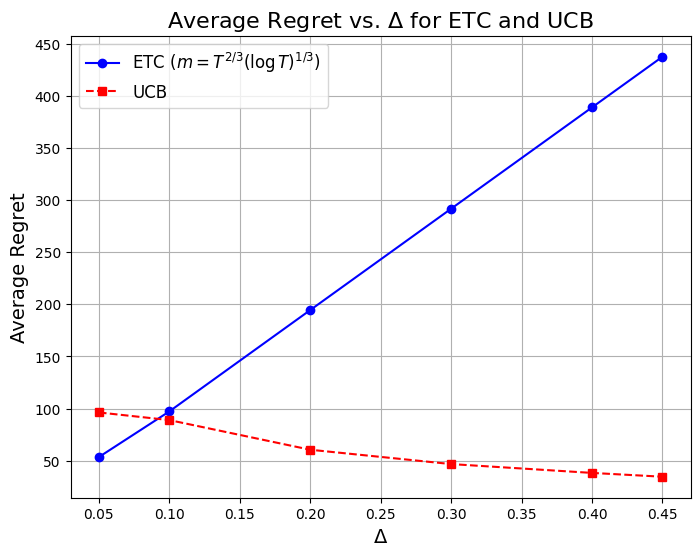

In [10]:
def run_ucb(T, delta):
    """
    Executes one simulation of the UCB algorithm for a two-armed bandit where
    the true means are given by mu1 = 0.5 and mu2 = 0.5 + delta.

    The algorithm starts by playing each arm once to initialize estimates.
    For each round t from 3 to T, it computes the UCB index for each arm as:

        UCB_i = (empirical mean of arm i) + sqrt((2 * ln t) / (number of plays of arm i))

    The arm with the higher UCB index is selected.

    The total regret is computed as:

        Total Regret = T * mu2 - (n1 * mu1 + n2 * mu2),

    where n1 and n2 denote the number of times arms 1 and 2 were played, respectively.
    """
    # Retrieve the true means for both arms.
    mu1, mu2 = true_means(delta)

    # Initialization: play each arm once.
    n1, n2 = 1, 1
    reward_sum1 = np.random.binomial(1, mu1)
    reward_sum2 = np.random.binomial(1, mu2)

    # For rounds 3 to T, calculate the UCB index for each arm and select the best one.
    for t in range(3, T + 1):
        ucb1 = (reward_sum1 / n1) + np.sqrt((2 * np.log(t)) / n1)
        ucb2 = (reward_sum2 / n2) + np.sqrt((2 * np.log(t)) / n2)

        if ucb1 >= ucb2:
            # Select arm 1.
            reward = np.random.binomial(1, mu1)
            reward_sum1 += reward
            n1 += 1
        else:
            # Select arm 2.
            reward = np.random.binomial(1, mu2)
            reward_sum2 += reward
            n2 += 1

    # After T rounds, compute the cumulative regret.
    total_regret = T * mu2 - (n1 * mu1 + n2 * mu2)
    return total_regret

# For each delta in our list, run the UCB simulation multiple times.
avg_regrets_ucb = []
for d in deltas:
    # Run 'num_runs' simulations for the current delta.
    regrets = [run_ucb(T, d) for _ in range(num_runs)]
    avg_regrets_ucb.append(np.mean(regrets))

# Plot the average regret as a function of delta for both ETC and UCB.
plt.figure(figsize=(8, 6))
plt.plot(deltas, avg_regrets_etc, 'bo-', label=r'ETC ($m=T^{2/3}(\log T)^{1/3}$)')
plt.plot(deltas, avg_regrets_ucb, 'rs--', label='UCB')
plt.xlabel(r'$\Delta$', fontsize=14)
plt.ylabel('Average Regret', fontsize=14)
plt.title('Average Regret vs. $\Delta$ for ETC and UCB', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Part 4: ETC with Known $\Delta$ (Optimal Exploration Length)

When $\Delta$ is known, we can set the exploration budget as

$$
m = \left\lceil \frac{2}{\Delta^2}\ln(2T) \right\rceil,
$$

which, by Hoeffding’s inequality, guarantees that the estimation error is below $\Delta/2$ with probability at least $1 - \frac{1}{T}$. In this section, we run the ETC algorithm using this optimal choice of \(m\) for each $\Delta$ and compare its performance with that of the UCB algorithm.
  

Average m (exploration rounds per arm) for each Delta (ETC with known Δ):
Delta = 0.05 : m = 7923.0
Delta = 0.1 : m = 1981.0
Delta = 0.2 : m = 496.0
Delta = 0.3 : m = 221.0
Delta = 0.4 : m = 124.0
Delta = 0.45 : m = 98.0


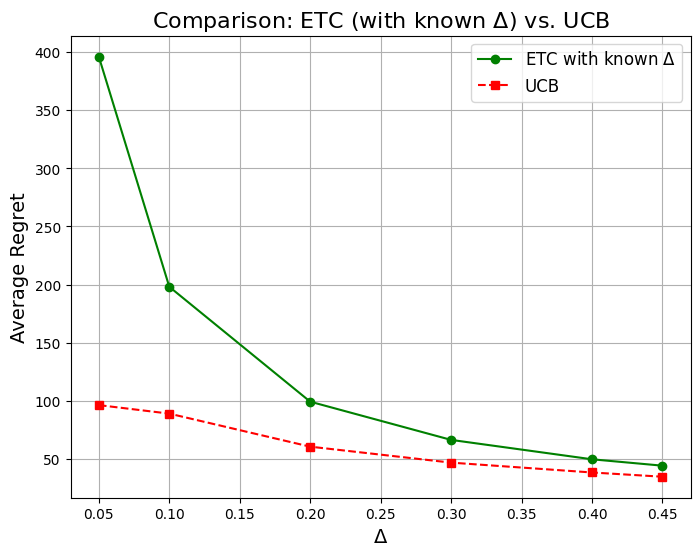

In [11]:
import math

def run_etc_known_delta(T, delta):
    """
    Execute the ETC algorithm under the assumption that \(\Delta\) is known.

    Here, we set the exploration budget as:

    $$ m = \left\lceil \frac{2}{\Delta^2}\ln(2T) \right\rceil, $$

    ensuring, via Hoeffding’s inequality, that the estimation error is bounded by \(\Delta/2\)
    with high probability. This function returns both the total regret incurred and the chosen
    exploration length m.
    """
    mu1, mu2 = true_means(delta)
    m = int(np.ceil((2 / (delta**2)) * np.log(2 * T)))

    # Exploration phase: play each arm m times.
    samples_arm1 = np.random.binomial(1, mu1, m)
    samples_arm2 = np.random.binomial(1, mu2, m)
    est_mean1 = np.mean(samples_arm1)
    est_mean2 = np.mean(samples_arm2)

    # Commit to the arm with the higher estimated mean (favoring arm 2 in the event of a tie).
    chosen_arm = 2 if est_mean2 >= est_mean1 else 1

    # The exploration phase incurs a regret of m * delta (since arm1 is suboptimal).
    regret_exploration = m * delta

    # During the commitment phase, if the optimal arm (arm 2) is chosen, no additional regret is incurred;
    # otherwise, the regret is accumulated over the remaining T - 2*m rounds.
    regret_commit = 0 if chosen_arm == 2 else (T - 2 * m) * delta

    total_regret = regret_exploration + regret_commit
    return total_regret, m

# For each delta value, run the ETC simulation (with known Δ) 500 times and record the average regret and m.
avg_regrets_etc_known = []
ms = []
for d in deltas:
    regrets = []
    m_values = []
    for _ in range(num_runs):
        reg, m_val = run_etc_known_delta(T, d)
        regrets.append(reg)
        m_values.append(m_val)
    avg_regrets_etc_known.append(np.mean(regrets))
    ms.append(np.mean(m_values))

print('Average m (exploration rounds per arm) for each Delta (ETC with known Δ):')
for d, m_val in zip(deltas, ms):
    print('Delta =', d, ': m =', m_val)

# Plot the average regret for ETC (with known Δ) versus Delta, and compare with UCB.
plt.figure(figsize=(8, 6))
plt.plot(deltas, avg_regrets_etc_known, 'go-', label=r'ETC with known $\Delta$')
plt.plot(deltas, avg_regrets_ucb, 'rs--', label='UCB')
plt.xlabel(r'$\Delta$', fontsize=14)
plt.ylabel('Average Regret', fontsize=14)
plt.title('Comparison: ETC (with known $\Delta$) vs. UCB', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Final Observations

1. **ETC (with fixed exploration length):** When using
   $m = T^{2/3}(\log T)^{1/3}$, the way the average regret scales with $\Delta$ differs from the scenario where \(m\) is chosen optimally with prior knowledge of $\Delta$.

2. **UCB:** The UCB algorithm adapts its exploration dynamically and often results in lower regret compared to the ETC approach with a predetermined exploration phase.

3. **ETC with known $\Delta$:** By setting the exploration length to
   $$ m = \left\lceil \frac{2}{\Delta^2}\ln(2T) \right\rceil, $$
   we greatly reduce the chance of committing to the wrong arm. In our experiments, this variant of ETC performs much closer to UCB.

Overall, these experiments underscore the tradeoffs between fixed exploration–commitment strategies and adaptive algorithms like UCB in the multi‑armed bandit setting.
